In [1]:
!pip install -r requirements.txt
# !pip install tensorflow yfinance pandas sklearn

In [2]:
import pandas as pd
import tensorflow as tf
import yfinance as yf

In [4]:
from datetime import datetime, timedelta
end_date = datetime.today().strftime('%Y-%m-%d')
start_date_dt = datetime.now() - timedelta(days=10*365)
start_date = start_date_dt.strftime('%Y-%m-%d')
goog = yf.download("GOOG", start = start_date, end = end_date)

2012-05-22 23:27:13.033654
2012-05-22
2022-05-20
[*********************100%***********************]  1 of 1 completed


In [5]:
df = pd.DataFrame(goog)
df1 = df.reset_index()['Close']

0        299.278229
1        303.592072
2        300.702881
3        294.660553
4        296.060303
           ...     
2511    2330.310059
2512    2295.850098
2513    2334.030029
2514    2248.020020
2515    2214.909912
Name: Close, Length: 2516, dtype: float64

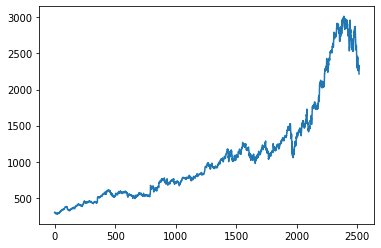

In [6]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [8]:
# Split data
train_size = int(len(df1)*.95) # 95%
test_size = len(df1) - train_size
train, test = df1[0:train_size,:], df1[train_size:len(df1), :1]

In [10]:
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [14]:
# Reshape to be inputted into LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

(2289, 100, 1)
(25, 100, 1)


In [15]:
# Create Stacked LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(Dropout(.5))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-traina

In [17]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=250, verbose=1)

Epoch 1/100
10/10 [==============================] - 10s 484ms/step - loss: 0.0405 - val_loss: 0.0270
Epoch 2/100
10/10 [==============================] - 3s 338ms/step - loss: 0.0077 - val_loss: 0.0576
Epoch 3/100
10/10 [==============================] - 4s 380ms/step - loss: 0.0025 - val_loss: 0.0253
Epoch 4/100
10/10 [==============================] - 4s 381ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 5/100
10/10 [==============================] - 4s 385ms/step - loss: 9.6670e-04 - val_loss: 0.0099
Epoch 6/100
10/10 [==============================] - 4s 378ms/step - loss: 6.2913e-04 - val_loss: 0.0227
Epoch 7/100
10/10 [==============================] - 4s 379ms/step - loss: 6.4307e-04 - val_loss: 0.0168
Epoch 8/100
10/10 [==============================] - 4s 390ms/step - loss: 6.3038e-04 - val_loss: 0.0098
Epoch 9/100
10/10 [==============================] - 4s 387ms/step - loss: 5.8039e-04 - val_loss: 0.0143
Epoch 10/100
10/10 [==============================] - 4s 390ms/step - 

In [20]:
prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 1), dtype=tf.float32, name='lstm_input'), name='lstm_input', description="created by layer 'lstm_input'")


In [21]:
prediction = scaler.inverse_transform(prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [22]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, prediction))

1161.3206983334346

In [23]:
math.sqrt(mean_squared_error(y_test, test_prediction))

2621.8088744775187

In [26]:
x_input = test[len(test)-100:].reshape(1, -1)

(1, 100)

In [27]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [29]:
# Prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while i<30:
    if len(temp_input)>100:
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

1 day input [0.96926202 0.96559201 0.95591991 0.95880762 0.95399718 0.9045546
 0.90380523 0.89980993 0.91128411 0.92183722 0.93375734 0.91535625
 0.92014839 0.89459005 0.88992213 0.87423687 0.8492744  0.85132135
 0.82473583 0.84304563 0.8421756  0.87265049 0.89026205 0.90619952
 0.98046205 0.94108638 0.94375848 0.91394523 0.91595569 0.93233178
 0.91149249 0.8787952  0.88734873 0.89557698 0.90334099 0.86547861
 0.85201959 0.84423362 0.83094631 0.86814705 0.88164266 0.88435866
 0.87907301 0.8833388  0.88009644 0.86411516 0.82275465 0.82870561
 0.87686515 0.86820916 0.85207804 0.82477608 0.84611976 0.87558211
 0.88223487 0.89832583 0.89596447 0.92373799 0.91076873 0.93130094
 0.93283252 0.9359652  0.94546917 0.94104247 0.91914682 0.92682676
 0.94833867 0.92948057 0.9010637  0.89586577 0.87792151 0.84711401
 0.83671815 0.85069264 0.82851918 0.83369515 0.85248383 0.83577504
 0.81159112 0.77267237 0.79925424 0.77188285 0.73909042 0.77119193
 0.7386957  0.75470982 0.76181959 0.79431948 0.7517

In [30]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [31]:
print(scaler.inverse_transform(lst_output[0:]))

[[2214.90991211]]
[[2531.05738047]
 [2530.24778582]
 [2532.12803474]
 [2537.35379293]
 [2545.92603874]
 [2557.34629668]
 [2570.80758105]
 [2585.38044784]
 [2600.17100021]
 [2614.39736375]
 [2627.44773604]
 [2638.88821345]
 [2648.45545354]
 [2656.02748714]
 [2661.60643405]
 [2665.27545505]
 [2667.18489179]
 [2667.5237312 ]
 [2666.50493012]
 [2664.35954505]
 [2661.30901197]
 [2657.58715942]
 [2653.40188934]
 [2648.95882085]
 [2644.43471136]
 [2639.98919696]
 [2635.7775111 ]
 [2631.88216233]
 [2628.40979212]
 [2625.42317869]]


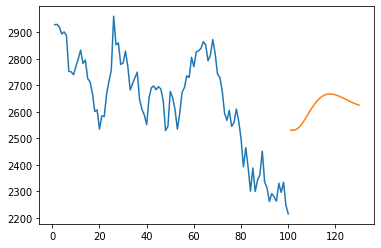

In [32]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

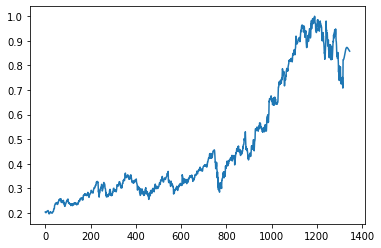

In [33]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [34]:
df3=scaler.inverse_transform(df3).tolist()

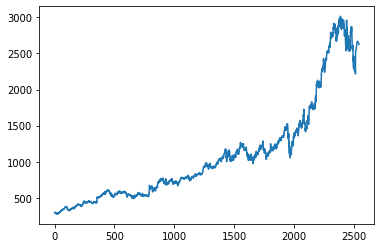

In [35]:
plt.plot(df3)

In [39]:
import time
from datetime import datetime

SECONDS_IN_DAY = 86400

now = int( time.time() )

data_set = {"c": [], "t": []}
inversed_output = scaler.inverse_transform(lst_output)
inversed_output.tolist()
for i in range(len(inversed_output)):
    now = SECONDS_IN_DAY + now
    data_set["c"].insert(i, round(float(inversed_output[i]), 2))
    data_set["t"].insert(i, int(now))

1653107659
2022-05-20 23:34:19
NEXT DAY

1653194059
2022-05-21 23:34:19
2625.42
1655699659
2022-05-24 23:34:19
{'c': [2531.06, 2530.25, 2532.13, 2537.35, 2545.93, 2557.35, 2570.81, 2585.38, 2600.17, 2614.4, 2627.45, 2638.89, 2648.46, 2656.03, 2661.61, 2665.28, 2667.18, 2667.52, 2666.5, 2664.36, 2661.31, 2657.59, 2653.4, 2648.96, 2644.43, 2639.99, 2635.78, 2631.88, 2628.41, 2625.42], 't': [1653194059, 1653280459, 1653366859, 1653453259, 1653539659, 1653626059, 1653712459, 1653798859, 1653885259, 1653971659, 1654058059, 1654144459, 1654230859, 1654317259, 1654403659, 1654490059, 1654576459, 1654662859, 1654749259, 1654835659, 1654922059, 1655008459, 1655094859, 1655181259, 1655267659, 1655354059, 1655440459, 1655526859, 1655613259, 1655699659]}


In [40]:
import json
with open('../src/stock_json/goog.json', 'w', encoding='utf-8') as f:
    json.dump(data_set, f, ensure_ascii=False, indent=4)